In [75]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
from copy import deepcopy
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, f1_score, mean_squared_error, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [120]:
train = pd.read_csv('training.csv')

In [121]:
# Check number of rows and columns
print(train.shape)

(12906, 83)


In [89]:
train.describe()

,patient_id,patient_zip3,patient_age,bmi,population,density,age_median,age_under_10,age_10_to_19,age_20s,...,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,DiagPeriodL90D
count,12906.000000,12906.000000,12906.000000,3941.000000,12905.000000,12905.000000,12905.000000,12905.000000,12905.000000,12905.000000,...,12905.000000,12902.000000,12902.000000,12905.000000,12905.000000,12905.000000,12877.000000,12877.000000,12877.000000,12906.000000
mean,547381.196033,573.754300,59.183326,28.984539,20744.441237,1581.950419,40.502259,11.122784,12.945265,13.290376,...,13.335299,13.406950,4.474956,27.978387,8.575284,7.083376,39.822352,7.475221,16.098988,0.624516
std,260404.959974,275.447534,13.335216,5.696906,13886.903756,2966.305306,4.036963,1.512376,1.923974,3.354103,...,3.690949,5.222495,4.837085,5.083939,4.203482,3.109022,3.559492,1.516499,5.842501,0.484266
min,100063.000000,101.000000,18.000000,14.000000,635.545455,0.916667,20.600000,0.000000,6.314286,5.925000,...,4.600000,3.433333,0.000000,12.460784,2.440000,1.200000,30.939316,2.636008,2.760371,0.000000
25%,321517.000000,331.000000,50.000000,24.660000,9463.896552,171.857143,37.129825,10.160000,11.741176,11.013415,...,10.270492,9.663333,0.994444,24.933333,5.618750,4.929688,37.698880,6.651215,11.280694,0.000000
50%,543522.000000,554.000000,59.000000,28.190000,19154.190480,700.337500,40.639344,11.039216,12.923944,12.538095,...,12.884000,12.177778,2.747222,27.788235,7.465714,6.847059,39.108249,7.686577,15.589148,1.000000
75%,772671.750000,846.000000,67.000000,32.920000,30021.278690,1666.515385,42.934783,12.190000,14.019767,14.971053,...,15.555405,16.635556,5.976000,30.709375,10.617442,8.620000,41.136513,8.276922,20.801880,1.000000
max,999896.000000,999.000000,91.000000,85.000000,71374.131580,21172.000000,54.570000,17.675000,35.300000,62.100000,...,35.155556,38.347826,26.755000,48.020000,27.566102,25.200000,52.237210,11.169408,31.504775,1.000000


In [122]:
train['patient_zip3'] = train['patient_zip3'].astype(str).str.zfill(5)

In [123]:
# Check the number of NA in each column
train.isna().sum().sort_values(ascending=False)

metastatic_first_novel_treatment         12882
metastatic_first_novel_treatment_type    12882
bmi                                       8965
patient_race                              6385
payer_type                                1803
                                         ...  
breast_cancer_diagnosis_code                 0
patient_gender                               0
patient_age                                  0
patient_zip3                                 0
DiagPeriodL90D                               0
Length: 83, dtype: int64

In [124]:
# Remove the columns with more than 50% of NA and drop the columns that are not useful (ID, desc)
#train = train.drop(columns=['metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type', 'bmi', 'patient_id', 'breast_cancer_diagnosis_desc'])

# Check the number of NA in each row
train.isna().sum(axis=1).sort_values(ascending=False)

# Remove the rows with more than 5 NA values
train = train.dropna(thresh=74)

# Columns to drop
columns_to_drop = ['metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type', 'bmi', 'patient_id', 'breast_cancer_diagnosis_desc']
train = train.drop(columns_to_drop, axis=1)

## EDA

In [125]:
# Check number of each category in each column
train['DiagPeriodL90D'].value_counts()

# Dataset is skewed

1    8058
0    4843
Name: DiagPeriodL90D, dtype: int64

In [ ]:
# Create a heat map visualization of DiagPeriodL90D by zip code

## Data Processing 1

In [212]:
# Define features and target variable
X = deepcopy(train.drop(columns=['DiagPeriodL90D']))
y = deepcopy(train['DiagPeriodL90D'])

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.7, random_state=42)

In [213]:
# Define a function to process numeric columns
def process_numeric_features(df):
    numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
    df[numeric_features] = SimpleImputer(strategy='mean').fit_transform(df[numeric_features])
    df[numeric_features] = MinMaxScaler().fit_transform(df[numeric_features])
    return df

In [214]:
X_train = process_numeric_features(X_train)
X_val = process_numeric_features(X_val)

In [160]:
# Build a transformer
def transform(df):
    categorical_columns = df.select_dtypes(include='object').columns

    pipeline_cat = Pipeline(
        steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("cat", pipeline_cat, categorical_columns)
        ]
    )

    return preprocessor

In [216]:
# Apply transformer
preprocessor_train = transform(X_train)
X_train = preprocessor_train.fit_transform(X_train)
X_val = preprocessor_train.transform(X_val)

X_train = pd.DataFrame(X_train.toarray(), columns=preprocessor_train.get_feature_names_out())
X_val = pd.DataFrame(X_val.toarray(), columns=preprocessor_train.get_feature_names_out())

In [217]:
# check type and shape of X_train
print(type(X_train))
print(X_train.shape)
print(X_val.shape)

<class 'pandas.core.frame.DataFrame'>
(3870, 767)
(9031, 767)


## Linear Regression

In [153]:
X_train_array = X_train.toarray()
X_val_array = X_val.toarray()

In [ ]:
# Fit the OLS model
model = sm.OLS(y_train, X_train_array)
results = model.fit()

# Print the regression results
print(results.summary())

In [ ]:
# Make prediction on test set
y_pred = results.predict(X_val_array)

# Compute R-squared for test set
r2_score(y_pred, y_val)

In [23]:
# Confidence interval
conf_int = results.conf_int()

# Filter features based on confidence intervals
not_significant = (conf_int[0]) > 0 & (conf_int[1] < 0)

len(not_significant[not_significant==True])/len(not_significant)
# 6% of the features are not significant based on the CI

0.06129398410896708

In [ ]:
# Remove insignificant features based on their confidence intervals
X_train_sign = X_train_array[:, ~not_significant]
X_val_sign = X_val_array[:, ~not_significant]

# Refit the linear regression
model2 = sm.OLS(y_train, X_train_sign)
results2 = model2.fit()
print(results2.summary())

In [22]:
# Make prediction on test set
y_pred_sign = results2.predict(X_val_sign)

# Compute R-squared
r2_score(y_pred_sign, y_val)

-0.4734966974659207

## XGBoost

In [163]:
import xgboost as xgb

# Create an XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

# Define a grid of hyperparameters to search over
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1], 
    'n_estimators': [100, 200, 300]
}

In [164]:
# Create a GridSearchCV object to find the best hyperparameters with MSE
grid_search = GridSearchCV(xgb_classifier, param_grid, cv=5, scoring='roc_auc')

In [165]:
# Fit the model to the data and find the best hyperparameters
grid_search.fit(X_train, y_train)  # X and y are your data and labels

# Get the best parameters and the best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

In [166]:
# Make prediction on the test data
y_pred = best_estimator.predict(X_val)

# Evaluate the model
mse = mean_squared_error(y_val, y_pred)

print("Best hyperparameters:", best_params)
print("f1:", f1_score(y_val, y_pred))
print("AUC:", roc_auc_score(y_val, y_pred))

Best hyperparameters: {'learning_rate': 0.01, 'n_estimators': 200}
f1: 0.8618436589781941
AUC: 0.7508365015702523


In [167]:
confusion_matrix = pd.crosstab(y_val, y_pred, rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

print(classification_report(y_val, y_pred))

Predicted     0     1
Actual               
0          1802  1567
1           188  5474
              precision    recall  f1-score   support

           0       0.91      0.53      0.67      3369
           1       0.78      0.97      0.86      5662

    accuracy                           0.81      9031
   macro avg       0.84      0.75      0.77      9031
weighted avg       0.83      0.81      0.79      9031



## Test

In [223]:
test = pd.read_csv('test.csv')
test.shape

(5792, 82)

In [225]:
test['patient_zip3'] = test['patient_zip3'].astype(str).str.zfill(5)

X_test = test.copy()
X_test = test.drop(columns=columns_to_drop)

In [226]:
X_test = preprocessor_train.transform(test)
X_test = pd.DataFrame(X_test.toarray(), columns=preprocessor_train.get_feature_names_out())

In [227]:
# Make prediction on the test data - XGBoost
y_pred = best_estimator.predict(X_test)

# Save the prediction to a CSV file with two columns: patient_id and DiagPeriodL90D
submission = pd.DataFrame({'patient_id': test['patient_id'], 'DiagPeriodL90D': y_pred})
submission.to_csv('submission.csv', index=False)

## Random Forest

### Modeling

In [247]:
# Define grid search
param_grid = {
    'n_estimators': [300, 400],
    'max_depth': [None, 20, 30],
    'min_samples_split': [10, 20, 25]
}

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42, bootstrap=True)

# Perform the grid search
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, 
                           scoring='roc_auc', cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

# Get the best parameters and the best estimator
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

<IPython.core.display.Javascript object>

Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [275]:
# Make prediction on the test data
predicted_probabilities = best_rf_model.predict_proba(X_val)

# Adjust decision threshold
custom_threshold = 0.56
y_pred = np.vstack((predicted_probabilities[:, 1] >= custom_threshold).astype(int))

# Calculate the F1 score for the best model
f1_score_best_model = f1_score(y_val, y_pred)

print("Best hyperparameters:", best_params)
print(f"F1 score for best model: {f1_score_best_model}")
print("AUC:", roc_auc_score(y_val, y_pred))

Best hyperparameters: {'max_depth': 20, 'min_samples_split': 25, 'n_estimators': 400}
F1 score for best model: 0.8640861236444234
AUC: 0.7574378208275654


In [277]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.90      0.55      0.68      3369
         1.0       0.78      0.96      0.86      5662

    accuracy                           0.81      9031
   macro avg       0.84      0.76      0.77      9031
weighted avg       0.83      0.81      0.80      9031



In [279]:
feature_importances_df

,Feature,Importance
684,cat__breast_cancer_diagnosis_code_1749,0.523398
680,cat__breast_cancer_diagnosis_code_1744,0.120084
683,cat__breast_cancer_diagnosis_code_1748,0.099823
677,cat__breast_cancer_diagnosis_code_1741,0.038539
678,cat__breast_cancer_diagnosis_code_1742,0.036254
...,...,...
271,cat__patient_zip3_00394,0.000000
272,cat__patient_zip3_00395,0.000000
273,cat__patient_zip3_00396,0.000000
274,cat__patient_zip3_00398,0.000000


In [278]:
# Feature importance
feature_importances = best_estimator.feature_importances_
feature_importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
inspect = pd.DataFrame(feature_importances_df[feature_importances_df['Importance'] < 0.001])

df = pd.DataFrame(columns=['feature', 'total_count', 'unimportant_count'])

for column in train.columns:
    total_count = train[column].nunique()
    unimportant_count = (inspect['Feature'].str.startswith('cat__'+column)).sum()
    new_row = {'feature':column, 'total_count': total_count, 'unimportant_count': unimportant_count}
    df = df.append(new_row, ignore_index=True)

df.sort_values(by='unimportant_count', ascending=True)

,feature,total_count,unimportant_count
38,income_household_50_to_75,725,0
55,education_stem_degree,728,0
54,education_college_or_above,736,0
53,education_graduate,732,0
52,education_bachelors,733,0
...,...,...,...
9,Division,9,8
7,metastatic_cancer_diagnosis_code,43,27
6,breast_cancer_diagnosis_code,50,34
2,patient_state,50,44


### Test

In [280]:
# Make prediction on the test data - Random Forest
predicted_probabilities = best_rf_model.predict_proba(X_test)

# Adjust decision threshold
custom_threshold = 0.56
y_pred = np.vstack((predicted_probabilities[:, 1] >= custom_threshold).astype(int))
y_pred = pd.DataFrame(y_pred, columns=["DiagPeriodL90D"])

# Save the prediction to a CSV file with two columns: patient_id and DiagPeriodL90D
submission = pd.DataFrame({'patient_id': test['patient_id'], 'DiagPeriodL90D': y_pred['DiagPeriodL90D']})
submission.to_csv('submission.csv', index=False)

## PyCaret

In [ ]:
import pyforest
import pycaret
pycaret.__version__
from pycaret.classification import ClassificationExperiment

In [ ]:
train2 = pd.read_csv('training.csv')
train2['patient_zip3'] = train2['patient_zip3'].astype(str).str.zfill(5)
# Remove the rows with more than 5 NA values
train2 = train2.dropna(thresh=74)

# Columns to drop
columns_to_drop = ['metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type', 'bmi', 'patient_id', 'breast_cancer_diagnosis_desc']
train2 = train2.drop(columns_to_drop, axis=1)

process_numeric_features(train2)
categorical_columns = train2.select_dtypes(include='object').columns
train2[categorical_columns] = OneHotEncoder(handle_unknown='ignore').fit_transform(train2[categorical_columns])

In [186]:
# Set up pycaret environment
exp1 = ClassificationExperiment()
exp1.setup(data = train, target = 'DiagPeriodL90D', session_id=123, experiment_name='breast_cancer')

,Description,Value
0,Session id,123
1,Target,DiagPeriodL90D
2,Target type,Binary
3,Original data shape,"(12901, 78)"
4,Transformed data shape,"(12901, 95)"
5,Transformed train set shape,"(9030, 95)"
6,Transformed test set shape,"(3871, 95)"
7,Numeric features,68
8,Categorical features,9
9,Rows with missing values,58.5%


In [ ]:
# compare baseline models
best = exp1.compare_models()

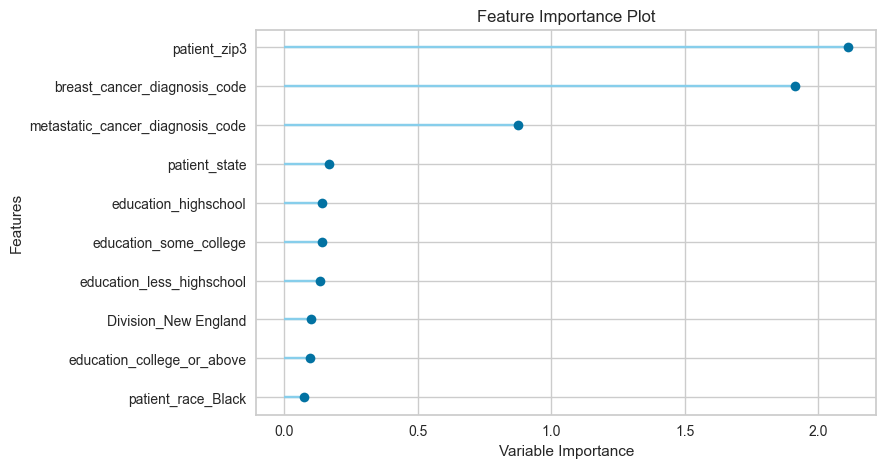

In [190]:
# Feature Importance
exp1.plot_model(best, plot = 'feature')

In [ ]:
# predict model on new_data
predictions = exp1.predict_model(best, data = test)
predictions.head()

results = predictions[['patient_id', 'prediction_label']]
results.to_csv("submission.csv", index=False)